# Causal Analysis with Geospatial Data

In [1]:
import rasterio
import numpy as np
import pandas as pd
from dowhy import CausalModel
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm   

In [2]:
import os
os.chdir('/home/vittekm/s3/uc2-data/CML')
os.getcwd()

'/home/vittekm/s3/uc2-data/CML'

## Define Raster Reading Function

In [3]:
# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        affine = src.transform
        return data, affine

## Load Raster Files

In [6]:

# Paths to raster files
treatment_raster_path = "CRI.tif"  # Crop Rotation Index
outcome_raster_path = "normalized_richness_arable.tiff"  # Biodiversity index
confounder1_raster_path = "LGN_2018_arable_r2.tif"  # LGN all clesses
covariate1_raster_path = "SWF_2018_arable_r2.tif"  # SWF
covariate2_raster_path = "greenness_spring.tif"  # greenness spring
covariate3_raster_path = "greenness_autumn.tif"  # greenness autumn

# Read rasters
treatment_data, _ = read_raster(treatment_raster_path)
outcome_data, _ = read_raster(outcome_raster_path)
confounder1_data, _ = read_raster(confounder1_raster_path)
covariate1_data, _ = read_raster(covariate1_raster_path)
covariate2_data, _ = read_raster(covariate2_raster_path)
covariate3_data, _ = read_raster(covariate3_raster_path)

# crop_rotation_index, _ = read_raster(treatment_raster_path)
# species_richness, _ = read_raster(outcome_raster_path)
# greenness_spring, _ = read_raster(confounder1_raster_path)
# greenness_autumn, _ = read_raster(confounder2_raster_path)
# LGN, _ = read_raster(covariate1_raster_path)
# OHN, _ = read_raster(covariate2_raster_path)
# NDVI, _ = read_raster(covariate3_raster_path)

## Process Raster Data

In [7]:

# Flatten rasters and create a DataFrame
rows, cols = treatment_data.shape
treatment_flat = treatment_data.flatten()
outcome_flat = outcome_data.flatten()
confounder1_flat = confounder1_data.flatten()
covariate1_flat = covariate1_data.flatten()
covariate2_flat = covariate2_data.flatten()
covariate3_flat = covariate3_data.flatten()

# Filter out nodata values (assuming 9999 as nodata value)
valid_mask = (
    (treatment_flat != 9999) &
    (outcome_flat != 9999) &
    (confounder1_flat != 9999) &
    (covariate1_flat != 99) &
    (covariate2_flat != 9999) &
    (covariate3_flat != 9999)
)

# Keep only valid data
df = pd.DataFrame({
    "treatment": treatment_flat[valid_mask],
    "outcome": outcome_flat[valid_mask],
    "confounder1": confounder1_flat[valid_mask],
    "covariate1": covariate1_flat[valid_mask],
    "covariate2": covariate2_flat[valid_mask],
    "covariate3": covariate3_flat[valid_mask],
})
    

## Create a Custom Causal Graph

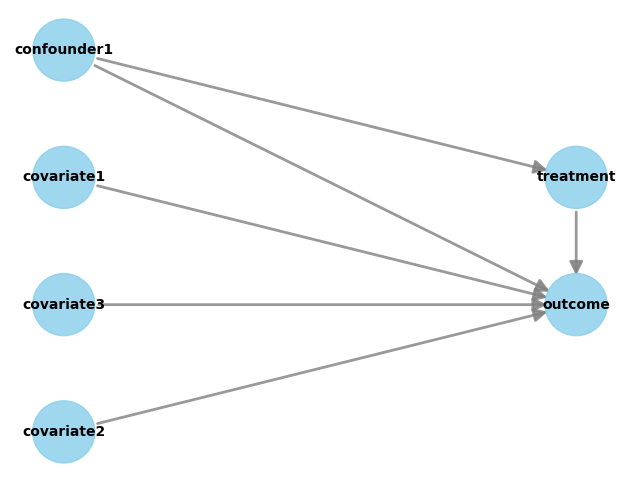

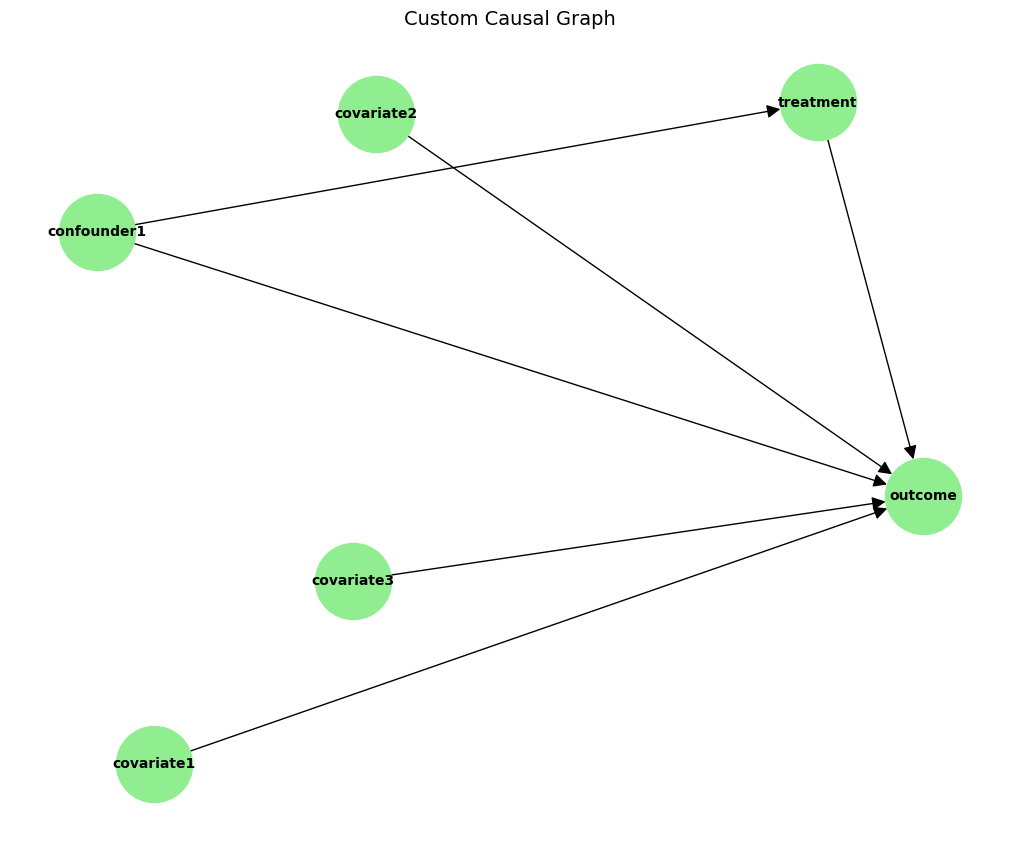

NameError: name 'causal_graph_to_dot' is not defined

In [20]:
# --- Create a custom causal graph ---
causal_graph = nx.DiGraph()
causal_graph.add_edges_from([
    ("confounder1", "treatment"),
    ("confounder1", "outcome"),
    ("covariate1", "outcome"),
    ("covariate2", "outcome"),
    ("covariate3", "outcome"),
    ("treatment", "outcome"),
])

# # Define the causal graph structure
# causal_graph = """
# digraph {
#     crop_rotation_frequency -> species_abundance;
#     crop_rotation_frequency -> LGN;
#     LGN -> species_abundance;
#     crop_rotation_frequency -> greenness;
#     greenness -> species_abundance;
# }
# """
 
# Create causal model
causal_model = CausalModel(
    data=df, # This is the preprocessed dataset
    treatment="treatment",
    outcome="outcome",
    graph=causal_graph
)

# Display the graph for verification
model.view_model()

# Visualize the graph using NetworkX
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(causal_graph)
nx.draw(
    causal_graph,
    pos,
    with_labels=True,
    node_color="lightgreen",
    node_size=3000,
    font_size=10,
    font_weight="bold",
    arrowsize=20
)
plt.title("Custom Causal Graph", fontsize=14)
plt.show()

# Convert graph to DoWhy-compatible DOT format
graph_dot = causal_graph_to_dot({
    "treatment": ["treatment"],
    "outcome": ["outcome"],
    "common_causes": ["confounder1"],
    "effect_modifiers": ["covariate1", "covariate2", "covariate3"],
})
    

In [21]:
causal_graph_dot = """
digraph {
    treatment -> outcome;
    confounder1 -> treatment;
    confounder1 -> outcome;
    covariate1 -> outcome;
    covariate2 -> outcome;
    covariate3 -> outcome;
}
"""


## Define and Estimate the Causal Model

/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694da

Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[outcome|confounder1])
d[treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,confounder1,U) = P(outcome|treatment,confounder1)

## Realized estimand
b: outcome~treatment+confounder1+treatment*covariate3+treatment*covariate2+treatment*covariate1
Target units: 

## Estimate
Mean value: nan
### Conditional Estimates
__categorical__covariate3  __categorical__covariate2  __categorical__covariate1
(-0.001, 2.0]              (-0.001, 2.0]              (-0.001, 1.0]               NaN
                           (2.0, 3.0]                 (-0.001, 1.0]               NaN
(2.0, 3.0]                 (-0.001, 2.0]              (-0.001, 1.0]               NaN
                           (2.0, 3.0]     

/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


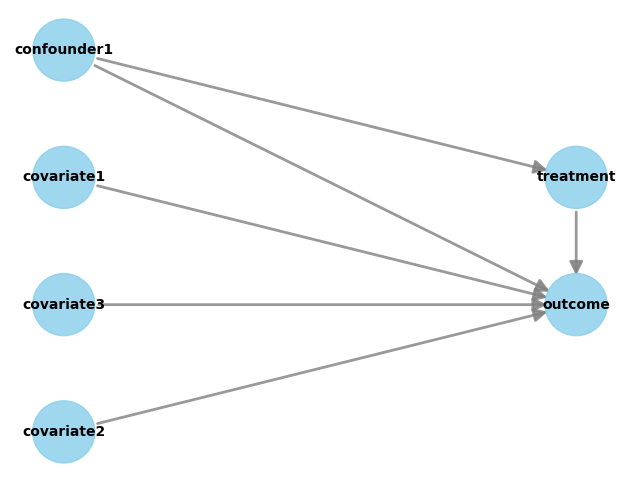

In [22]:

# Define the causal model using the custom graph
causal_model = CausalModel(
    data=df,
    treatment="treatment",
    outcome="outcome",
    graph=causal_graph_dot
)

# Identify the causal effect
identified_estimand = causal_model.identify_effect()

# # Estimate the causal effect
# causal_estimate = causal_model.estimate_effect(
#     identified_estimand,
#     method_name="backdoor.propensity_score_matching"
# )

causal_estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)


# Print the causal estimate
print("Causal Estimate:", causal_estimate)

# Visualize the causal graph in DoWhy format
causal_model.view_model()
    

In [23]:
# Refute the causal estimate
refutation = causal_model.refute_estimate(
    identified_estimand, causal_estimate, method_name="placebo_treatment_refuter"
)
print("\nRefutation Result:")
print(refutation)

/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__ge


Refutation Result:
Refute: Use a Placebo Treatment
Estimated effect:nan
New effect:nan
p value:0.0



/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Visual Evaluation Metrics

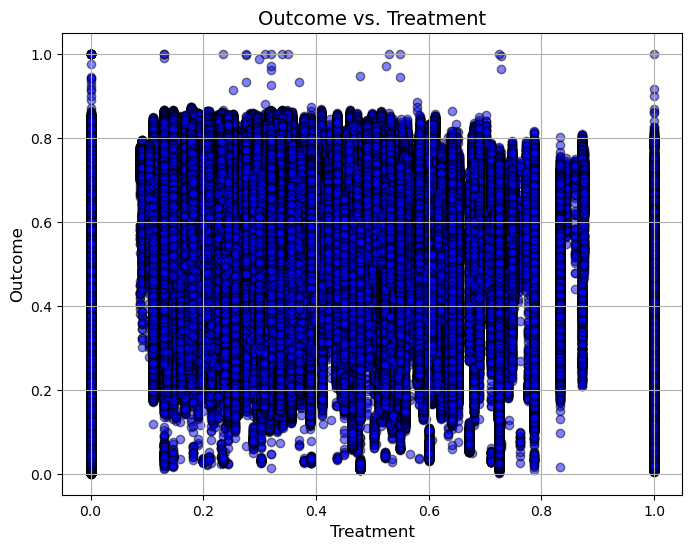

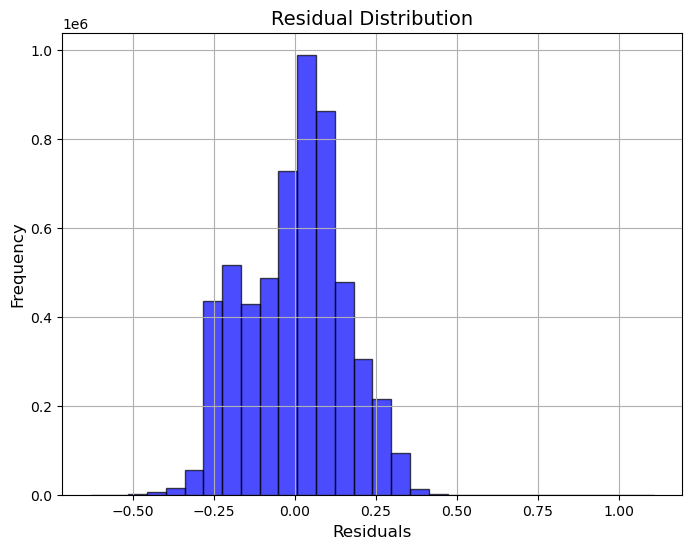

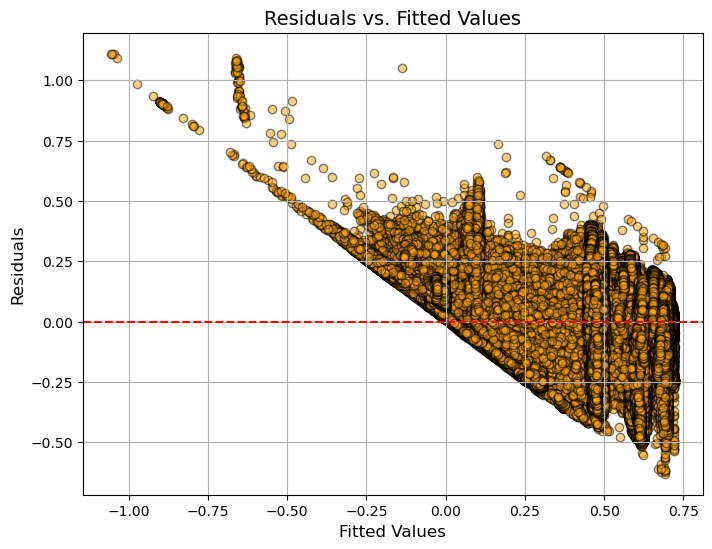

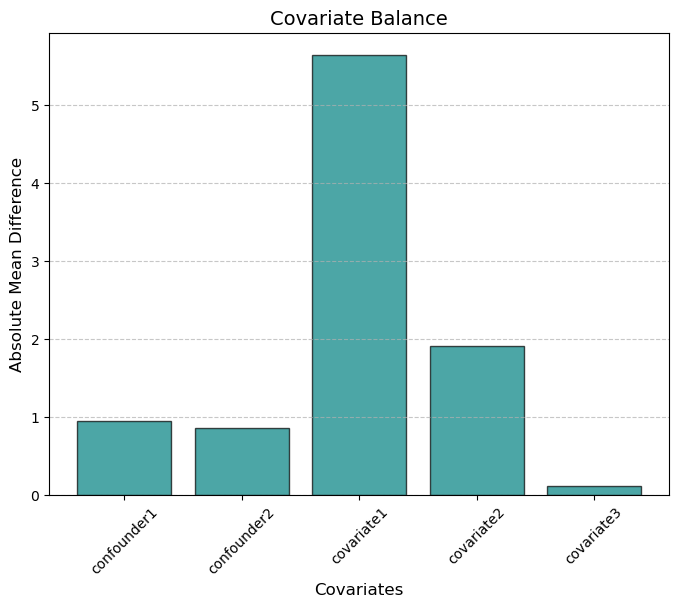

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# 1. Outcome vs. Treatment Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(df["treatment"], df["outcome"], alpha=0.5, edgecolor="k", color="blue")
plt.title("Outcome vs. Treatment", fontsize=14)
plt.xlabel("Treatment", fontsize=12)
plt.ylabel("Outcome", fontsize=12)
plt.grid(True)
plt.show()

# 2. Residual Analysis
# Fit a linear regression model for outcome ~ treatment + confounders + covariates
X = df[["treatment", "confounder1", "confounder2", "covariate1", "covariate2", "covariate3"]]
X = sm.add_constant(X)
y = df["outcome"]
model = sm.OLS(y, X).fit()

# Residuals of the regression model
residuals = model.resid

# Plot residuals to check for patterns
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Residual Distribution", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Residuals vs. Fitted Values
fitted = model.fittedvalues
plt.figure(figsize=(8, 6))
plt.scatter(fitted, residuals, alpha=0.5, edgecolor="k", color="orange")
plt.axhline(0, color="red", linestyle="--", linewidth=1.5)
plt.title("Residuals vs. Fitted Values", fontsize=14)
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)
plt.show()

# 3. Covariate Balance Check
# Assess the balance of covariates between low and high treatment levels (median split for visualization)
df["treatment_group"] = (df["treatment"] > df["treatment"].median()).astype(int)

covariates = ["confounder1", "confounder2", "covariate1", "covariate2", "covariate3"]
balance = {
    cov: abs(
        df[df["treatment_group"] == 1][cov].mean() - df[df["treatment_group"] == 0][cov].mean()
    )
    for cov in covariates
}

# Plot covariate balance
plt.figure(figsize=(8, 6))
plt.bar(balance.keys(), balance.values(), color="teal", alpha=0.7, edgecolor="black")
plt.title("Covariate Balance", fontsize=14)
plt.ylabel("Absolute Mean Difference", fontsize=12)
plt.xlabel("Covariates", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
